## Before usage
Remember to change the directory to your own drive path. The link can be found on [here](https://moodle.epfl.ch/pluginfile.php/3067678/mod_resource/content/2/RA_source_localization.zip). If it's not available, please refer to [here](https://drive.google.com/drive/folders/1SnwZ1C7byMqM5JzPYVmHWUP69hkM-6ob?usp=sharing).

Uncomment the bolck below to use this script on Google Colab.

In [11]:
# If it's executing on a Google Colab, otherwise comment out these lines
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

# !pip install ImoT-tools

In [1]:
# Include the paths to load the file. Change this to your own directory
data_source_path = '../RA_source_localization/data.npz'

In [2]:
import numpy as np
from scipy.linalg import eigh
from tqdm import tqdm
import matplotlib.pyplot as plt
import imot_tools.io.s2image as s2 # imot_tools only works with python version <= 3.7
from concurrent.futures import ProcessPoolExecutor, as_completed # concurrent execution to boost up the speed

import bluebild
import music


README of the dataset
===============================================================

`data.npz` contains real pre-processed data from the LOFAR radio-telescope observing the BOOTES field during 8 hours.

Note: a Short-Time-Interval (STI) corresponds to 8 seconds.

* `XYZ`: (N_time, N_antenna, 3) antenna positions per STIs
* `W`: (N_time, N_antenna, N_antenna) recorded beamforming weights per STI
* `S`: (N_time, N_antenna, N_antenna) recorded visibilities per STI
* `px_grid`: (N_px, 3) cartesian coordinates of the sky region to estimate. (HEALPIX tesselation)
* `lambda_`: observation wavelength
* `catalog`: (N_src, 3) cartesian coordinates of the major sources present in the field.

You may find the `ImoT-tools` library [1] useful for plotting spherical images.

[1] https://pypi.org/project/ImoT-tools/

Access of variable in this notebook
====================================
We simple use the variable `data` as a `dict` with the tag names mentioned above to access them.

In [3]:
data = np.load(data_source_path)
n_time, n_antenna, _ = np.shape(data['XYZ'])
n_px, _  = np.shape(data['px_grid'])
n_src, _ = np.shape(data['catalog'])
time_step = 8   # unit [s]
print(f"Loading preprocessed LOFAR radio-telescope data...\n\
Number of time samples: {n_time}\n\
Number of Antennas: {n_antenna}\n\
Number of pixels of sky: {n_px}\n\
Number of major light sources: {n_src}\n\
Sampled with time interval: {time_step} secs")

Loading preprocessed LOFAR radio-telescope data...
Number of time samples: 3595
Number of Antennas: 24
Number of pixels of sky: 27524
Number of major light sources: 100
Sampled with time interval: 8 secs


### Function to plot the intensity


In [4]:
def intensity_plot(intensity, ax=None, star_size=50, linewidth=0.5, cmap='jet')->None:
    '''
    Plot the given intensity using a colormap, 
    with given ground truth defined in data['catalog']

    Params:
    intensity: the intensity function given by either Bluebild or MUSIC algorithm
    ax: the axis to plot on
    star_size: the size of the ground truth stars
    linewidth: the linewidth of the stars, less value means thinner
    cmap: the colormap used to plot
    '''
    img = s2.Image(intensity, data['px_grid'].T) # averaged by time
    axe, proj, scm = img.draw(use_contours=True,
                            data_kwargs={'cmap': cmap},
                            catalog=data['catalog'].T,
                            ax=ax,
                            catalog_kwargs={'s': star_size, 'edgecolors': 'w','marker': '*', 'linewidths': linewidth})
    if ax is None:
        fig = plt.gcf()
        fig.set_dpi(200)

## Test on the entire dataset

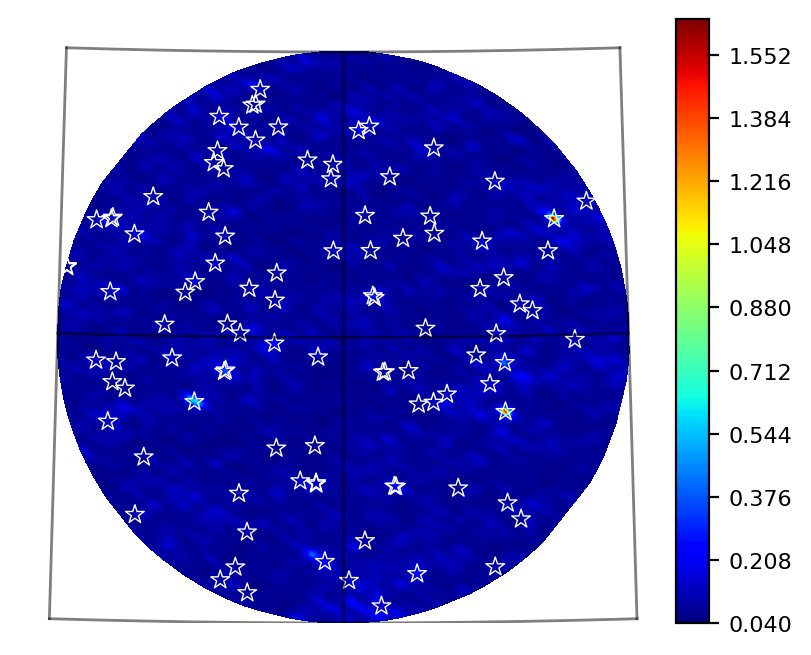

In [5]:
# Chnge size for prettier plotting
plt.rcParams.update({'font.size': 8})

intensity_music, music_eigvals = music.music(data['S'][0,:,:], data['W'][0,:,:], data['XYZ'][0,:,:], data['px_grid'], data['lambda_'], threshold=0.7, get_eigen=True)
intensity_plot(intensity_music)

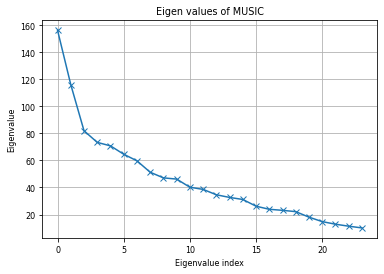

In [15]:
plt.plot(np.real(music_eigvals), '-x')
plt.title("Eigen values of MUSIC")
plt.xlabel("Eigenvalue index")
plt.ylabel("Eigenvalue")
plt.grid()

Calculate intensity from 0 with length 3595. Threshold = 0.8


100%|██████████| 120/120 [00:14<00:00,  8.10it/s]


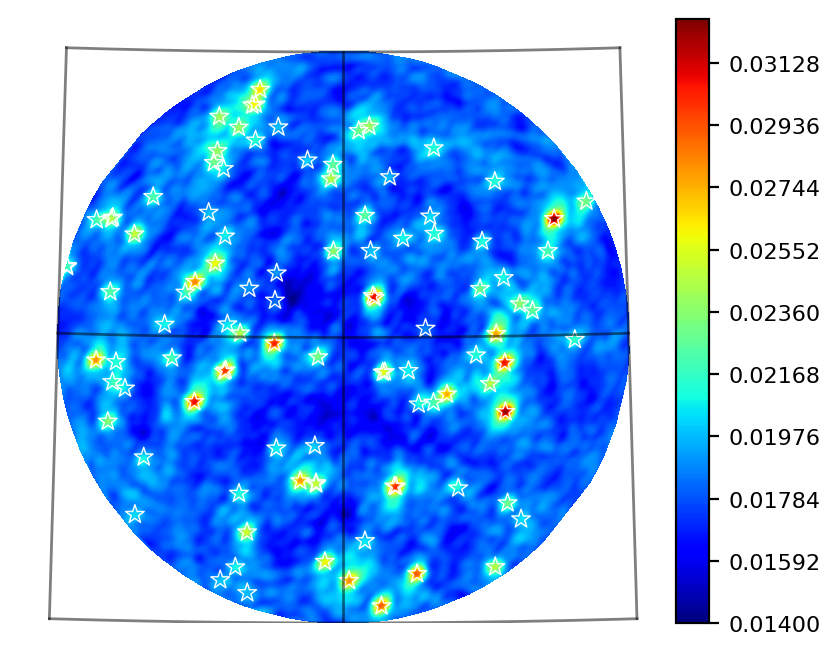

In [10]:
intensity_bluebild = bluebild.bluebild_long_exposure(data['S'], data['W'], data['XYZ'], data['px_grid'], data['lambda_'], 0.8, time_step=30, equalize=True)
intensity_plot(intensity_bluebild)

## Test of different threshold
Because it takes some time, we use concurrent method to run the results in parallel.

In [10]:
thresholds = [0.2, 0.4, 0.5, 0.7, 0.9, 1.0]
intensities = [None]*len(thresholds)

with ProcessPoolExecutor() as executor:
    futures = [ executor.submit(bluebild.bluebild_long_exposure, data['S'], data['W'], data['XYZ'], data['px_grid'], data['lambda_'], thr, None, 0, id) for id, thr in enumerate(thresholds) ]

    for s, f in enumerate(as_completed(futures)):
        intensities[s] = f.result()
        print(f'{s}: finished')

Calculate intensity from 0 with length 3595. Threshold = 0.2
Calculate intensity from 0 with length 3595. Threshold = 0.4
Calculate intensity from 0 with length 3595. Threshold = 0.5
Calculate intensity from 0 with length 3595. Threshold = 0.7
Calculate intensity from 0 with length 3595. Threshold = 0.9
Calculate intensity from 0 with length 3595. Threshold = 1.0
0: finished
1: finished
2: finished
3: finished
4: finished
5: finished


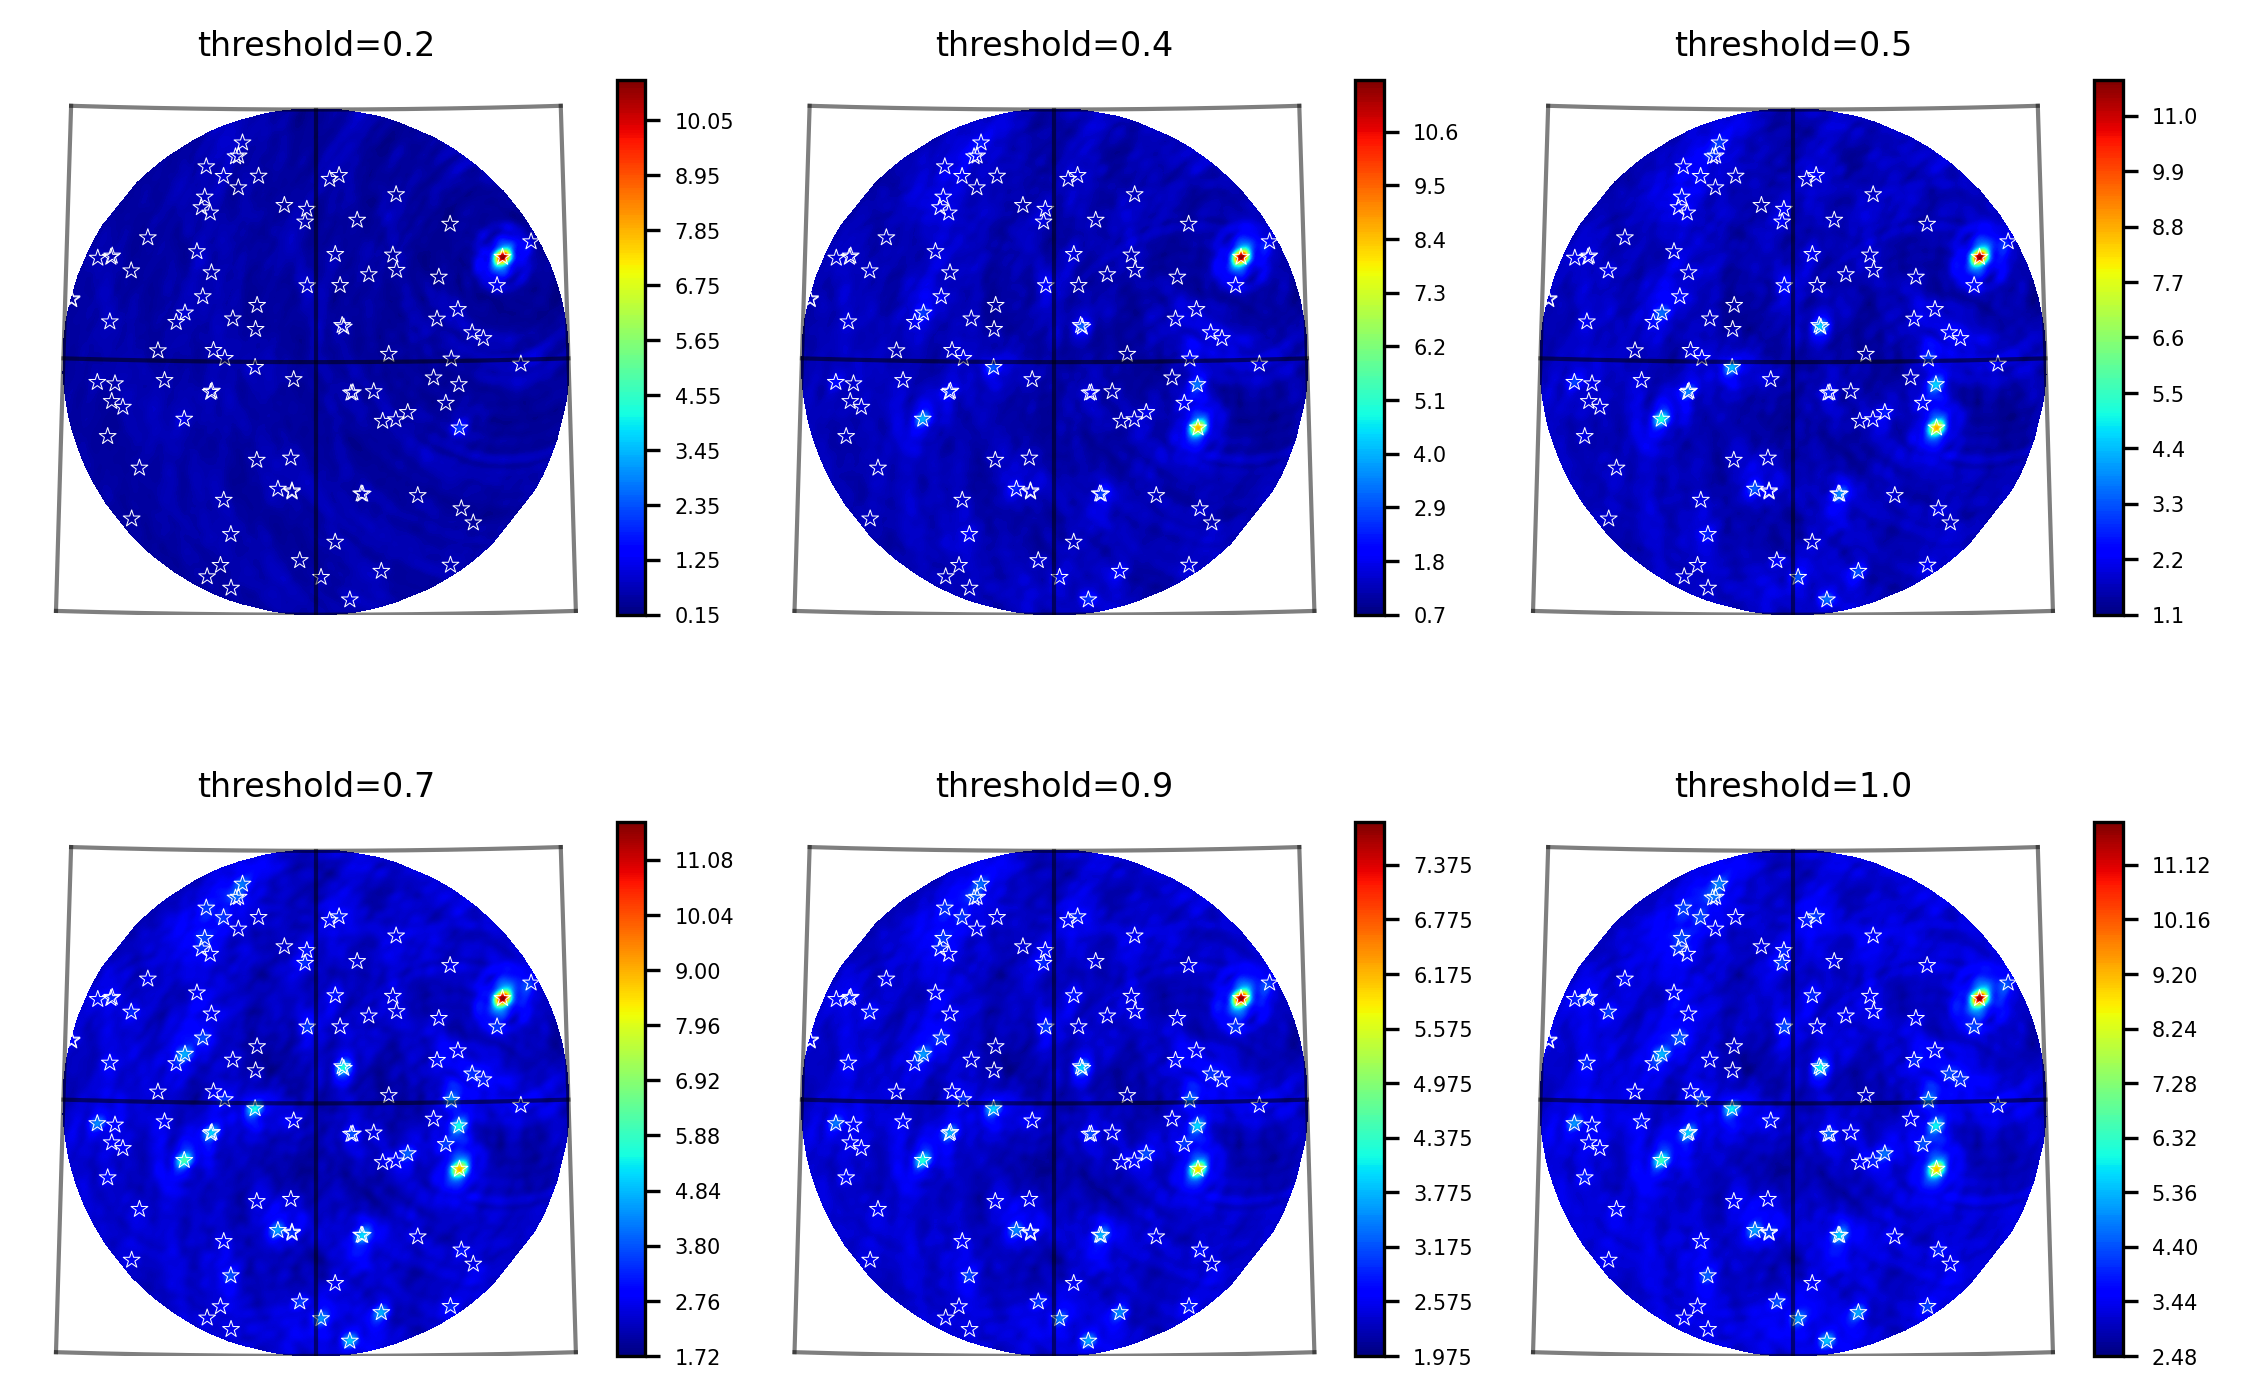

In [11]:
fig, axs = plt.subplots(2,3)
fig.set_dpi(300)
fig.set_size_inches(9,6)
title_fontsize = 8
plt.rcParams.update({'font.size': 5})

axs[0,0].set_title('threshold=0.2', fontsize=title_fontsize)
axs[0,1].set_title('threshold=0.4', fontsize=title_fontsize)
axs[0,2].set_title('threshold=0.5', fontsize=title_fontsize)
axs[1,0].set_title('threshold=0.7', fontsize=title_fontsize)
axs[1,1].set_title('threshold=0.9', fontsize=title_fontsize)
axs[1,2].set_title('threshold=1.0', fontsize=title_fontsize)

star_size=18
linewidth=0.25
intensity_plot(intensities[0], axs[0,0], star_size=star_size, linewidth=linewidth)
intensity_plot(intensities[1], axs[0,1], star_size=star_size, linewidth=linewidth)
intensity_plot(intensities[2], axs[0,2], star_size=star_size, linewidth=linewidth)
intensity_plot(intensities[3], axs[1,0], star_size=star_size, linewidth=linewidth)
intensity_plot(intensities[4], axs[1,1], star_size=star_size, linewidth=linewidth)
intensity_plot(intensities[5], axs[1,2], star_size=star_size, linewidth=linewidth)



## Test on the choice with different exposure time
Using concurrent modules to boost the speed

In [9]:
lengths = [1, 10, 50, 100, 300, 500, 1000, 2000, n_time] # number of frames to compute
intensities = [None]*len(lengths)

with ProcessPoolExecutor() as executor:
    futures = [ executor.submit(bluebild.bluebild_long_exposure, data['S'], data['W'], data['XYZ'], data['px_grid'], data['lambda_'], 0.9, l, 0, id) for id, l in enumerate(lengths) ]

    for s, f in enumerate(as_completed(futures)):
        intensities[s] = f.result()
        print(f'{s}: finished')


Calculate intensity from 0 with length 1. Threshold = 0.9
Calculate intensity from 0 with length 10. Threshold = 0.9
1: finished 10%
Calculate intensity from 0 with length 50. Threshold = 0.9
1: finished 20%
1: finished 30%
1: finished 40%
Calculate intensity from 0 with length 100. Threshold = 0.9
1: finished 50%
1: finished 60%
Calculate intensity from 0 with length 300. Threshold = 0.9
1: finished 70%
1: finished 80%2: finished 10%

0: finished
2: finished 10%
Calculate intensity from 0 with length 500. Threshold = 0.9
2: finished 10%
1: finished
2: finished 10%
Calculate intensity from 0 with length 1000. Threshold = 0.9
2: finished 10%
2: finished 20%
2: finished 20%
Calculate intensity from 0 with length 2000. Threshold = 0.9
2: finished 20%3: finished 10%

2: finished 20%3: finished 10%

Calculate intensity from 0 with length 3595. Threshold = 0.9
2: finished 20%
3: finished 10%
2: finished 30%3: finished 10%

2: finished 30%
3: finished 10%
2: finished 30%
3: finished 10%
2: fi

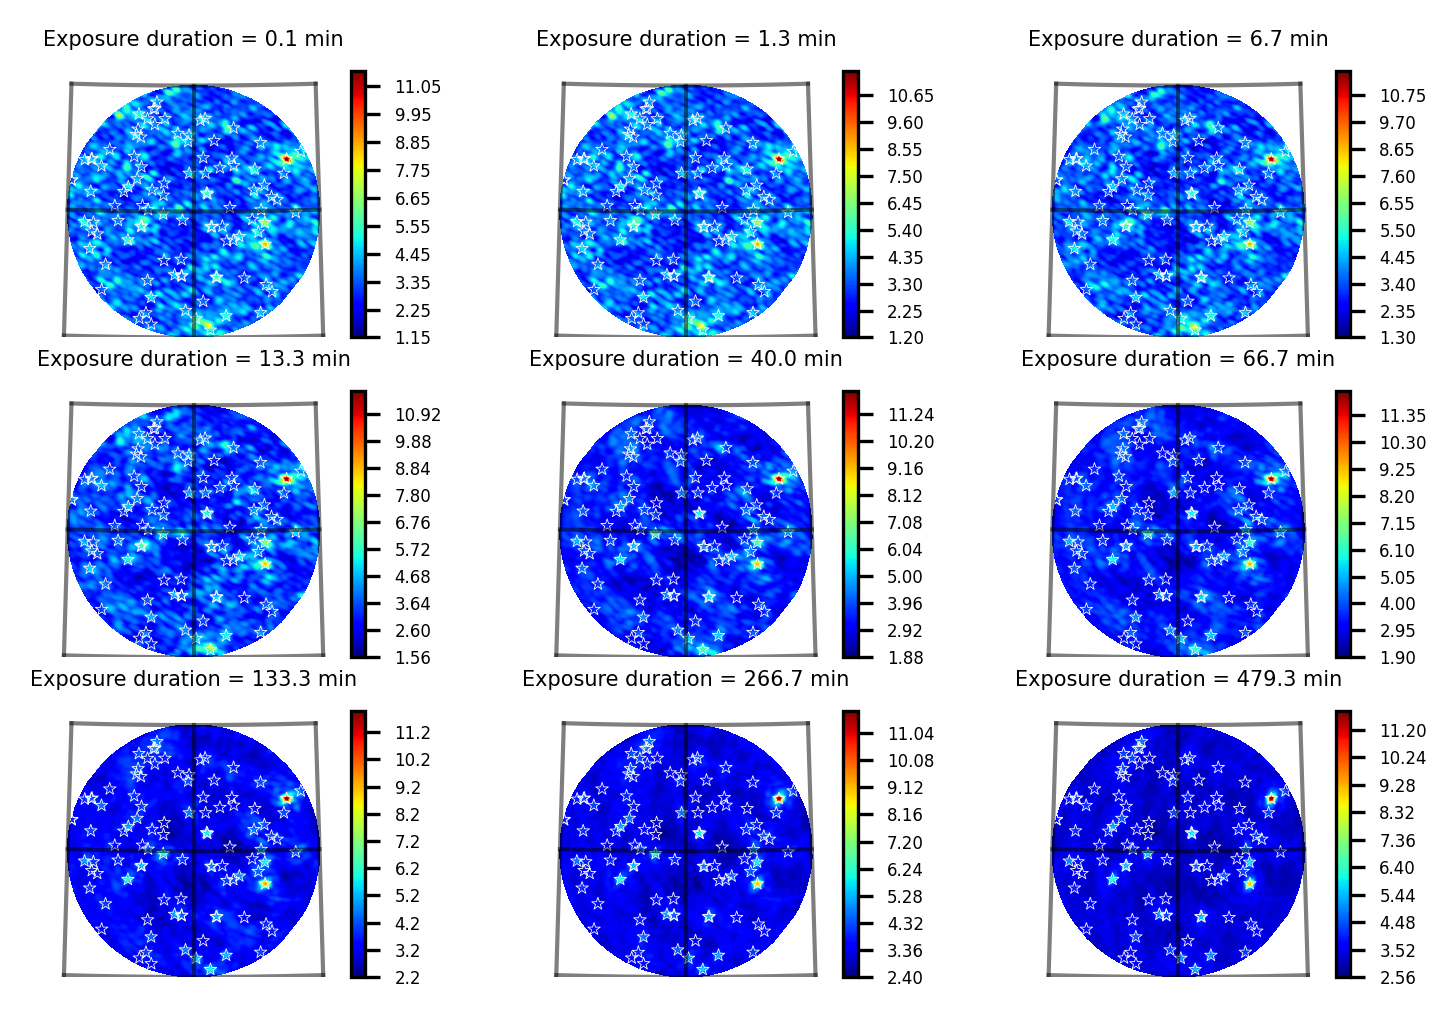

In [13]:
fig, axs = plt.subplots(3,3)
fig.set_dpi(300)
title_fontsize = 5
plt.rcParams.update({'font.size': 4})
star_size=10
linewidth=0.2

for i in range(3):
    for j in range(3):
        axs[i,j].set_title("Exposure duration = {:.1f} min".format(lengths[3*i+j] * time_step/60), fontsize=title_fontsize)
        intensity_plot(intensities[3*i+j], axs[i,j], star_size=star_size, linewidth=linewidth)


In [16]:
lengths = [1, 10, 50, 100, 300, 500, 1000, 2000, n_time]
intensities = [None]*len(lengths)

with ProcessPoolExecutor() as executor:
    futures = [ executor.submit(bluebild.bluebild_long_exposure, data['S'], data['W'], data['XYZ'], data['px_grid'], data['lambda_'], 0.9, time_window_lng=l, time_start=0, process_id=id, equalize=True) for id, l in enumerate(lengths) ]

    for s, f in enumerate(as_completed(futures)):
        intensities[s] = f.result()
        print(f'{s}: finished')


Calculate intensity from 0 with length 1. Threshold = 0.9
Calculate intensity from 0 with length 10. Threshold = 0.9
Calculate intensity from 0 with length 50. Threshold = 0.9
Calculate intensity from 0 with length 100. Threshold = 0.9
Calculate intensity from 0 with length 300. Threshold = 0.9
Calculate intensity from 0 with length 500. Threshold = 0.9
0: finished
1: finished
Calculate intensity from 0 with length 1000. Threshold = 0.9
Calculate intensity from 0 with length 2000. Threshold = 0.9
Calculate intensity from 0 with length 3595. Threshold = 0.9
2: finished
3: finished
4: finished
5: finished
6: finished
7: finished
8: finished


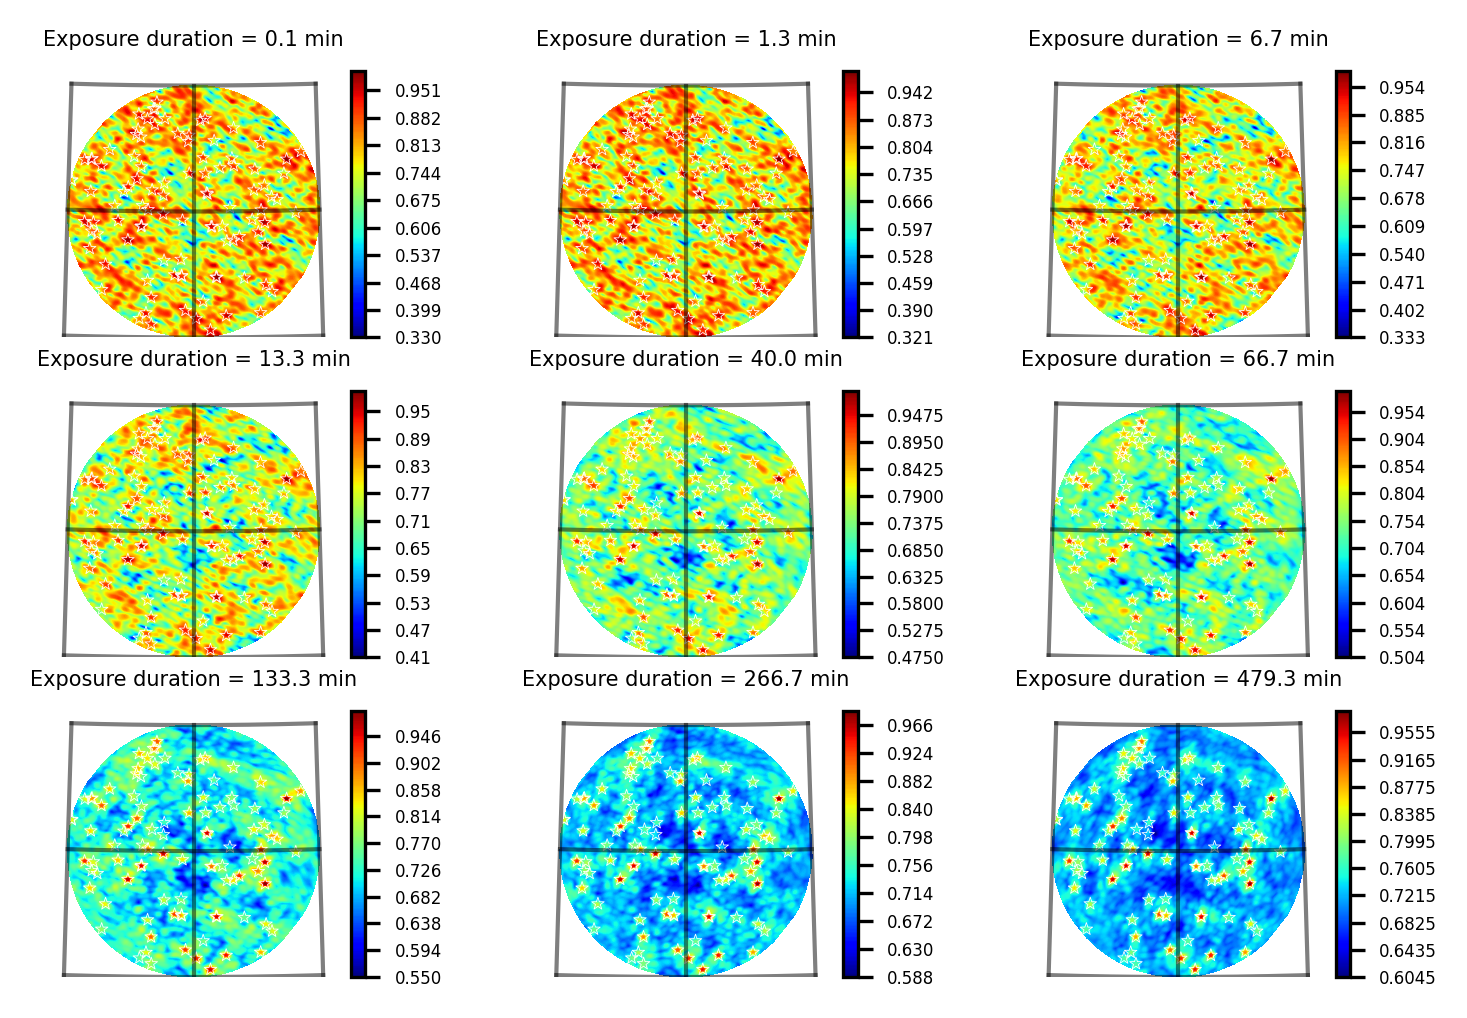

In [19]:
fig, axs = plt.subplots(3,3)
fig.set_dpi(300)
title_fontsize = 5
plt.rcParams.update({'font.size': 4})
star_size=10
linewidth=0.2

for i in range(3):
    for j in range(3):
        axs[i,j].set_title("Exposure duration = {min:.1f} min".format(min=(lengths[3*i+j] * time_step)/60), fontsize=title_fontsize)
        intensity_plot(intensities[3*i+j], axs[i,j], star_size=star_size, linewidth=linewidth)
